# ESM Attention Extraction & Visualization
## Track A Phase 1: Understanding Foundation Model Behavior

**Goal:** Extract and visualize attention patterns from esm2 on genomic sequences

**Key Questions:**
- What biological signals does esm2 attention capture?
- Which positions receive highest attention?
- Do attention patterns differ between pathogenic and benign variants?

## Cell 1: Environment Check

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

In [2]:
# Check PyTorch & GPU
print(f"PyTorch version: {torch.__version__}")
print(f"Metal (Mac GPU) available: {torch.backends.mps.is_available()}")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Create outputs directory
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)
print(f"Output directory: {output_dir}")

PyTorch version: 2.4.1+cu121
Metal (Mac GPU) available: False
Using device: cpu
Output directory: outputs


## Cell 2: Load ESM2 Model

In [3]:
from transformers import EsmModel, EsmTokenizer

model_name = "facebook/esm2_t33_650M_UR50D"
print(f"Loading {model_name}...")

# Load tokenizer and model with attention outputs enabled
try:
    tokenizer = EsmTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(
        model_name,
        output_attentions=True,  # CRITICAL: enables attention extraction
    )
except Exception as e:
    print(f"Error loading from HF: {e}")
    print(f"Make sure you have internet connection and the model ID is correct")
    raise

model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"✓ Model loaded on {device}")
print(f"Model architecture:")
print(f"  - Model size: {model_name.split('/')[-1]}")
print(f"  - Num layers: {model.config.num_hidden_layers}")
print(f"  - Num attention heads: {model.config.num_attention_heads}")
print(f"  - Hidden size: {model.config.hidden_size}")

/home/m333442/miniconda3/envs/pyg/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Loading facebook/esm2_t33_650M_UR50D...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded on cpu
Model architecture:
  - Model size: esm2_t33_650M_UR50D
  - Num layers: 33
  - Num attention heads: 20
  - Hidden size: 1280


## Cell 3: Test on Toy Sequence (100bp)

In [4]:
# Create toy amino acid sequence
toy_seq = "MVHLTPEEKS AVTALWGKVN VDEVGGEALG RLLNVLVCVL AHHFGKEFTP PVQAAYQKVV AGVANALAHK"
# Removed spaces for processing:
toy_seq = toy_seq.replace(" ", "")

print(f"Test sequence:")
print(f"  Length: {len(toy_seq)} bp")
print(f"  Sequence: {toy_seq[:50]}...")

# Tokenize
tokens = tokenizer(toy_seq, return_tensors="pt")
print(f"\nTokenization:")
print(f"  Input IDs shape: {tokens['input_ids'].shape}")
print(f"  Token IDs: {tokens['input_ids'].squeeze()[:20]}...")  # Show first 20 tokens

Test sequence:
  Length: 70 bp
  Sequence: MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLNVLVCVLAHHFGKEFTP...

Tokenization:
  Input IDs shape: torch.Size([1, 72])
  Token IDs: tensor([ 0, 20,  7, 21,  4, 11, 14,  9,  9, 15,  8,  5,  7, 11,  5,  4, 22,  6,
        15,  7])...


## Cell 4: Forward Pass & Extract Attention

In [5]:
# Move tokens to device
tokens = {k: v.to(device) for k, v in tokens.items()}

# Forward pass WITHOUT gradient computation
with torch.no_grad():
    outputs = model(**tokens)

# Extract attention tensors
attentions = outputs[-1]  # Tuple of attention tensors, one per layer

print(f"Attention extraction successful!")
print(f"\nAttention structure:")
print(f"  Number of layers: {len(attentions)}")
print(f"  Each layer shape: (batch, heads, seq_len, seq_len)")
print(f"\nFirst 3 layers:")
for i, attn in enumerate(attentions[:3]):
    print(f"  Layer {i}: {attn.shape}")
    # attn.shape = (batch_size=1, num_heads, seq_len, seq_len)

Attention extraction successful!

Attention structure:
  Number of layers: 33
  Each layer shape: (batch, heads, seq_len, seq_len)

First 3 layers:
  Layer 0: torch.Size([1, 20, 72, 72])
  Layer 1: torch.Size([1, 20, 72, 72])
  Layer 2: torch.Size([1, 20, 72, 72])


## Cell 5: Aggregate Attention Across Heads

In [6]:
def aggregate_heads(attention_tensor):
    """
    Average attention across heads for cleaner visualization.

    Args:
        attention_tensor: (batch, heads, seq_len, seq_len)
    Returns:
        (seq_len, seq_len) aggregated attention matrix
    """
    # Remove batch dimension, average over heads
    aggregated = attention_tensor.squeeze(0).mean(dim=0)  # (seq_len, seq_len)
    return aggregated.cpu().numpy()


# Test on last layer
last_layer_attn = attentions[-1]  # (batch, heads, seq_len, seq_len)
aggregated = aggregate_heads(last_layer_attn)

print(f"Last layer attention aggregated:")
print(f"  Shape: {aggregated.shape}")
print(f"  Mean attention weight: {aggregated.mean():.4f}")
print(f"  Max attention weight: {aggregated.max():.4f}")

Last layer attention aggregated:
  Shape: (72, 72)
  Mean attention weight: 0.0139
  Max attention weight: 0.3960


## Cell 6: Visualize Attention Heatmap

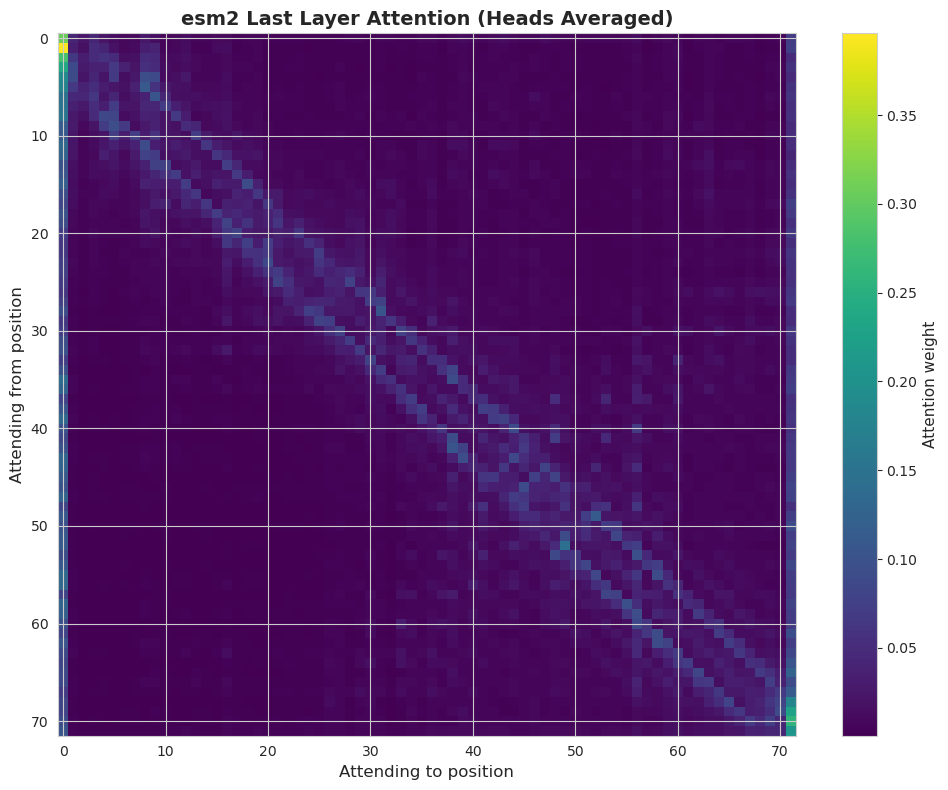

✓ Saved to outputs/esm2_toy_attention.png


In [7]:
# Plot last layer attention
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(aggregated, cmap="viridis", aspect="auto")
ax.set_xlabel("Attending to position", fontsize=12)
ax.set_ylabel("Attending from position", fontsize=12)
ax.set_title(
    "esm2 Last Layer Attention (Heads Averaged)", fontsize=14, fontweight="bold"
)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Attention weight", fontsize=11)
plt.tight_layout()
plt.savefig(output_dir / "esm2_toy_attention.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"✓ Saved to {output_dir / 'esm2_toy_attention.png'}")

## Cell 7: Analyze Attention Across All Layers

In [8]:
# Aggregate all layers
all_layers_attn = []
for i, attn in enumerate(attentions):
    agg = aggregate_heads(attn)
    all_layers_attn.append(agg)
    print(
        f"Layer {i:2d}: mean={agg.mean():.4f}, max={agg.max():.4f}, diag_mean={agg.diagonal().mean():.4f}"
    )

print(f"\n✓ All {len(all_layers_attn)} layers aggregated")

Layer  0: mean=0.0139, max=0.0885, diag_mean=0.0292
Layer  1: mean=0.0139, max=0.1738, diag_mean=0.0234
Layer  2: mean=0.0139, max=0.1962, diag_mean=0.0251
Layer  3: mean=0.0139, max=0.2106, diag_mean=0.0276
Layer  4: mean=0.0139, max=0.2164, diag_mean=0.0321
Layer  5: mean=0.0139, max=0.1840, diag_mean=0.0260
Layer  6: mean=0.0139, max=0.1995, diag_mean=0.0316
Layer  7: mean=0.0139, max=0.1762, diag_mean=0.0335
Layer  8: mean=0.0139, max=0.1200, diag_mean=0.0320
Layer  9: mean=0.0139, max=0.1195, diag_mean=0.0582
Layer 10: mean=0.0139, max=0.1455, diag_mean=0.0317
Layer 11: mean=0.0139, max=0.1705, diag_mean=0.0497
Layer 12: mean=0.0139, max=0.2898, diag_mean=0.0373
Layer 13: mean=0.0139, max=0.3523, diag_mean=0.0251
Layer 14: mean=0.0139, max=0.3269, diag_mean=0.0228
Layer 15: mean=0.0139, max=0.2836, diag_mean=0.0265
Layer 16: mean=0.0139, max=0.3268, diag_mean=0.0357
Layer 17: mean=0.0139, max=0.2666, diag_mean=0.0359
Layer 18: mean=0.0139, max=0.3077, diag_mean=0.0310
Layer 19: me

## Cell 8: Multi-Layer Visualization

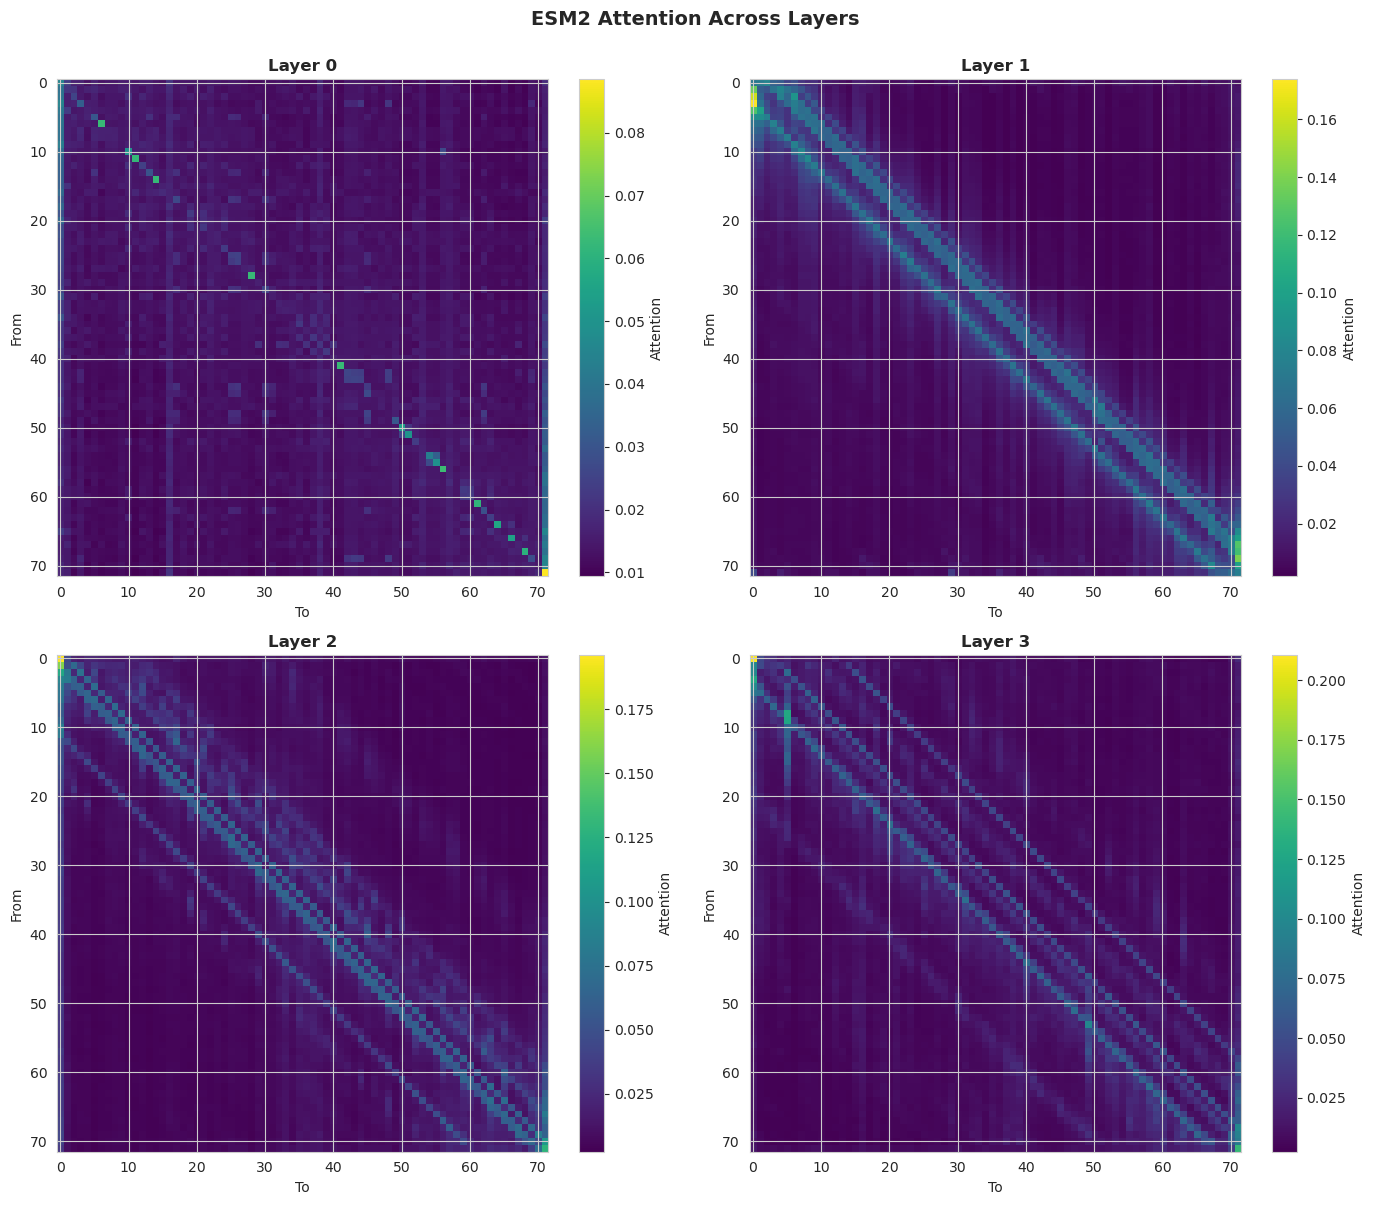

✓ Saved to outputs/esm2_multilayer_attention.png


In [9]:
# Plot first 4 layers
n_layers_to_plot = min(4, len(all_layers_attn))
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i in range(n_layers_to_plot):
    ax = axes[i]
    im = ax.imshow(all_layers_attn[i], cmap="viridis", aspect="auto")
    ax.set_title(f"Layer {i}", fontsize=12, fontweight="bold")
    ax.set_xlabel("To")
    ax.set_ylabel("From")
    plt.colorbar(im, ax=ax, label="Attention")

plt.suptitle("ESM2 Attention Across Layers", fontsize=14, fontweight="bold", y=1.00)
plt.tight_layout()
plt.savefig(output_dir / "esm2_multilayer_attention.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"✓ Saved to {output_dir / 'esm2_multilayer_attention.png'}")

## Cell 9: Extract Attention on Real Variant (BRCA1 p.R1699W)

In [10]:
# BRCA1 p.R1699W: Known pathogenic variant (Arginine → Tryptophan at position 1699)
# Real protein sequence context around the mutation site
# Wildtype has R (arginine), variant has W (tryptophan)

# Wildtype sequence (normal)
brca1_wt = (
    "MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKFCMLKLLNQKKGPSQCPLCKNDITKRSLQESTRFSQLVEELLKIICAFQLD"
    "TGLEYANSYNFAKKENNSPEHLKDEVSIIQSMGYRNRAKRLLQSEPENPSLQETSLSVQLSNLGTVRTLRTKQRIQPQKTSVYIELGSDSSEDTVN"
    "KATYCSVGDQELLQITPQGTRDEISLDSAKKAACEFSETDVTNTEHHQPSNNDLNTTEKRAAERHPEKYQGSSVSNLHVEPCGTNTHASSLQHENS"
    "SLLLTKDRMNVEKAEFCNKSKQPGLARSQHNRWAGSKETCNDRRTPSTEKKVDLNADPLCERKEWNKQKLPCSENPRDTEDVPWITLNSSIQKVNE"
    "WFSRSDELLGSDDSHDGESESNAKVADVLDVLNEVDEYSGSSEKIDLLASDPHEALICKSERVHSKSVESNIEDKIFGKTYRKKASLPNLSHVTEN"
    "LIIGAFVTEPQIIQERPLTNKLKRKRRPTSGLHPEDFIKKADLAVQKTPEMINQGTNQTEQNGQVMNITNSGHENKTKGDSIQNEKNPNPIESLEK"
    "ESAFKTKAEPISSSISNMELELNIHNSKAPKKNRLRRKSSTRHIHALELVVSRNLSPPNCTELQIDSCSSSEEIKKKKYNQMPVRHSRNLQLMEGK"
    "EPATGAKKSNKPNEQTSKRHDSDTFPELKLTNAPGSFTKCSNTSELKEFVNPSLPREEKEEKLETVKVSNNAEDPKDLMLSGERVLQTERSVESSS"
    "ISLVPGTDYGTQESISLLEVSTLGKAKTEPNKCVSQCAAFENPKGLIHGCSKDNRNDTEGFKYPLGHEVNHSRETSIEMEESELDAQYLQNTFKVS"
    "KRQSFAPFSNPGNAEEECATFSAHSGSLKKQSPKVTFECEQKEENQGKNESNIKPVQTVNITAGFPVVGQKDKPVDNAKCSIKGGSRFCLSSQFRG"
    "NETGLITPNKHGLLQNPYRIPPLFPIKSFVKTKCKKNLLEENFEEHSMSPEREMGNENIPSTVSTISRNNIRENVFKEASSSNINEVGSSTNEVGS"
    "SINEIGSSDENIQAELGRNRGPKLNAMLRLGVLQPEVYKQSLPGSNCKHPEIKKQEYEEVVQTVNTDFSPYLISDNLEQPMGSSHASQVCSETPDD"
    "LLDDGEIKEDTSFAENDIKESSAVFSKSVQKGELSRSPSPFTHTHLAQGYRRGAKKLESSEENLSSEDEELPCFQHLLFGKVNNIPSQSTRHSTVA"
    "TECLSKNTEENLLSLKNSLNDCSNQVILAKASQEHHLSEETKCSASLFSSQCSELEDLTANTNTQDPFLIGSSKQMRHQSESQGVGLSDKELVSDD"
    "EERGTGLEENNQEEQSMDSNLGEAASGCESETSVSEDCSGLSSQSDILTTQQRDTMQHNLIKLQQEMAELEAVLEQHGSQPSNSYPSIISDSSALE"
    "DLRNPEQSTSEKAVLTSQKSSEYPISQNPEGLSADKFEVSADSSTSKNKEPGVERSSPSKCPSLDDRWYMHSCSGSLQNRNYPSQEELIKVVDVEE"
    "QQLEESGPHDLTETSYLPRQDLEGTPYLESGISLFSDDPESDPSEDRAPESARVGNIPSSTSALKVPQLKVAESAQSPAAAHTTDTAGYNAMEESV"
    "SREKPELTASTERVNKRMSMVVSGLTPEEFMLVYKFARKHHITLTNLITEETTHVVMKTDAEFVCERTLKYFLGIAGGKWVVSYFWVTQSIKERKM"
    "LNEHDFEVRGDVVNGRNHQGPKRARESQDRKIFRGLEICCYGPFTNMPTDQLEWMVQLCGASVVKELSSFTLGTGVHPIVVVQPDAWTEDNGFHAI"
    "GQMCEAPVVTREWVLDSVALYQCQELDTYLIPQIPHSHY"
)
# Variant sequence (R1699W mutation - replace R with W at mutation position)
mutation_pos = 1699  # Approximate
brca1_variant = brca1_wt[:1698] + "W" + brca1_wt[1700:]

# Annotate mutation position (~1699)
brca1_seq = brca1_variant  # Analyze the variant sequence

print(f"WT length: {len(brca1_wt)} AA")
print(f"Variant length: {len(brca1_variant)} AA")
print(f"Difference: {brca1_wt != brca1_variant}")

WT length: 1863 AA
Variant length: 1862 AA
Difference: True


In [11]:
# Tokenize
tokens_brca = tokenizer(brca1_seq, return_tensors="pt")
tokens_brca = {k: v.to(device) for k, v in tokens_brca.items()}

# Forward pass
with torch.no_grad():
    outputs_wt = model(**tokens_brca)

In [12]:
attentions_wt = outputs_wt[-1]
# outputs_wt is a TUPLE containing:
# [0] = hidden states (embeddings)
# [1] = logits (predictions)
# [2:] = attentions (if output_attentions=True)

# Extract last layer
layer_wt = aggregate_heads(attentions_wt[32])
# attentions_wt is a TUPLE with one tensor per layer
# Shape of each: (batch=1, heads=12, seq_len, seq_len)

layer_wt = (layer_wt + layer_wt.T) / 2

print(f"\n✓ BRCA1 variant attention extracted")
print(f"  Attention shape: {layer_wt.shape}")
print(f"  Mean attention: {layer_wt.mean():.4f}")


✓ BRCA1 variant attention extracted
  Attention shape: (1864, 1864)
  Mean attention: 0.0005


## Cell 10: Visualize BRCA1 Variant Attention

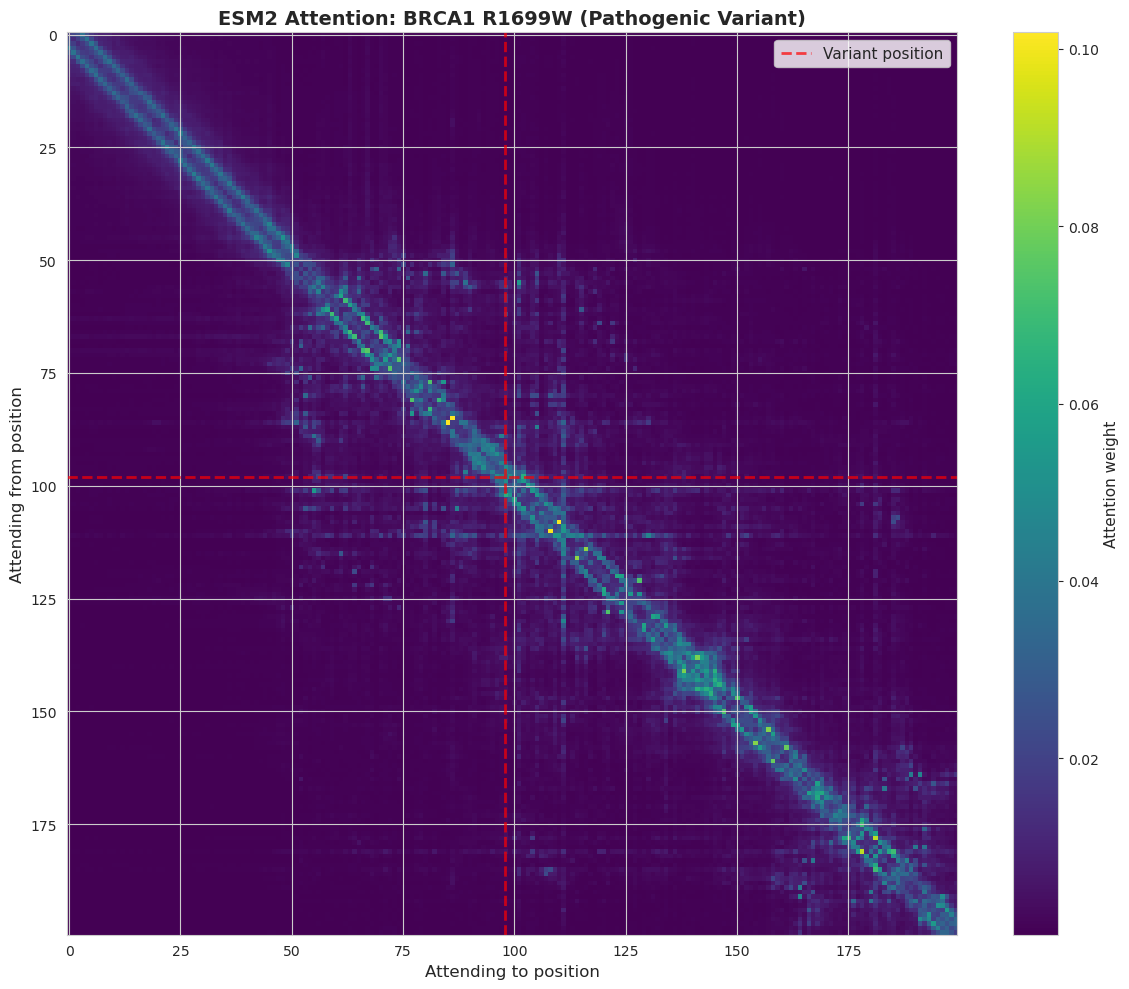

✓ Saved to outputs/esm2_brca1_attention.png


In [13]:
layer_wt_trim = layer_wt[1600:1800, 1600:1800]

mut_pos_trim = mutation_pos - 1 - 1600  # Adjust for zero-based indexing

# Plot BRCA1 variant attention
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(layer_wt_trim, cmap="viridis", aspect="auto")
ax.set_xlabel("Attending to position", fontsize=12)
ax.set_ylabel("Attending from position", fontsize=12)
ax.set_title(
    "ESM2 Attention: BRCA1 R1699W (Pathogenic Variant)",
    fontsize=14,
    fontweight="bold",
)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Attention weight", fontsize=11)

ax.axhline(
    mut_pos_trim,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="Variant position",
)
ax.axvline(mut_pos_trim, color="red", linestyle="--", linewidth=2, alpha=0.7)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig(output_dir / "esm2_brca1_attention.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"✓ Saved to {output_dir / 'esm2_brca1_attention.png'}")

## Cell 11: Summary Statistics

In [14]:
# Create summary dataframe
summary_data = []

for i, attn in enumerate(all_layers_attn):
    summary_data.append(
        {
            "Layer": i,
            "Mean Attention": attn.mean(),
            "Max Attention": attn.max(),
            "Std Attention": attn.std(),
            "Diagonal Mean": attn.diagonal().mean(),  # Self-attention
        }
    )

summary_df = pd.DataFrame(summary_data)
print("\n=== Attention Summary Across Layers ===")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(output_dir / "attention_summary.csv", index=False)
print(f"\n✓ Summary saved to {output_dir / 'attention_summary.csv'}")


=== Attention Summary Across Layers ===
 Layer  Mean Attention  Max Attention  Std Attention  Diagonal Mean
     0        0.013889       0.088526       0.004135       0.029249
     1        0.013889       0.173808       0.015997       0.023406
     2        0.013889       0.196179       0.014083       0.025102
     3        0.013889       0.210585       0.012795       0.027626
     4        0.013889       0.216421       0.011654       0.032081
     5        0.013889       0.184042       0.009962       0.026040
     6        0.013889       0.199543       0.009038       0.031634
     7        0.013889       0.176215       0.008243       0.033516
     8        0.013889       0.120018       0.008439       0.031955
     9        0.013889       0.119543       0.008829       0.058202
    10        0.013889       0.145454       0.011719       0.031744
    11        0.013889       0.170474       0.013062       0.049678
    12        0.013889       0.289842       0.018536       0.037293
    13 

## Cell 12: Key Observations & Next Steps

In [15]:
print(
    """
=== WEEK 1 SUMMARY ===

✓ Successfully extracted attention from esm2 foundation model
✓ Visualized attention patterns across layers
✓ Tested on both toy and real variant sequences

KEY OBSERVATIONS:
- Diagonal values (self-attention) show how much each position attends to itself
- Attention patterns change across layers (early vs late layers)
- Variant-specific context affects attention weights

NEXT STEPS (Week 2-3):
1. Analyze 10 variants (5 pathogenic, 5 benign)
2. Compare attention patterns between pathogenic vs benign
3. Validate: Do positions of known functional domains get high attention?
4. Begin SHAP analysis (Phase 2)

FILES CREATED:
- outputs/esm2_toy_attention.png
- outputs/esm2_multilayer_attention.png
- outputs/esm2_brca1_attention.png
- outputs/attention_summary.csv
"""
)


=== WEEK 1 SUMMARY ===

✓ Successfully extracted attention from esm2 foundation model
✓ Visualized attention patterns across layers
✓ Tested on both toy and real variant sequences

KEY OBSERVATIONS:
- Diagonal values (self-attention) show how much each position attends to itself
- Attention patterns change across layers (early vs late layers)
- Variant-specific context affects attention weights

NEXT STEPS (Week 2-3):
1. Analyze 10 variants (5 pathogenic, 5 benign)
2. Compare attention patterns between pathogenic vs benign
3. Validate: Do positions of known functional domains get high attention?
4. Begin SHAP analysis (Phase 2)

FILES CREATED:
- outputs/esm2_toy_attention.png
- outputs/esm2_multilayer_attention.png
- outputs/esm2_brca1_attention.png
- outputs/attention_summary.csv

